In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost.callback import EarlyStopping
import optuna

In [2]:
df =pd.read_csv('./train.csv')
test_df=pd.read_csv('./test.csv')

In [4]:
df["study_band"] = pd.cut(
    df["study_hours"],
    bins=[0, 2, 4, 6, 8],
    labels=[0, 1, 2, 3]
)

test_df["study_band"] = pd.cut(
    test_df["study_hours"],
    bins=[0, 2, 4, 6, 8],
    labels=[0, 1, 2, 3]
)

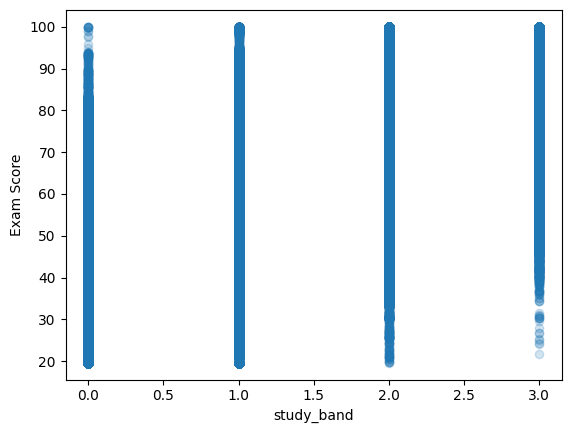

In [5]:
plt.scatter(df["study_band"], df["exam_score"], alpha=0.2)
plt.xlabel("study_band")
plt.ylabel("Exam Score")
plt.show()

In [6]:
df.groupby("study_band")["exam_score"].median()

C:\Users\rajes\AppData\Local\Temp\ipykernel_20808\1818735642.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("study_band")["exam_score"].median()


study_band
0    43.8
1    56.3
2    68.9
3    81.3
Name: exam_score, dtype: float64

In [9]:
# # df.head()
# df["study_band"] = df["study_band"].astype(int)
# test_df["study_band"] = test_df["study_band"].astype(int)
df["band_x_hours"] = df["study_band"] * df["study_hours"]

test_df["band_x_hours"] = test_df["study_band"] * test_df["study_hours"]

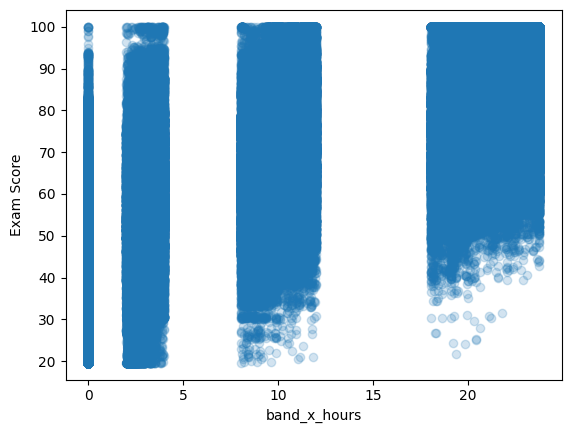

In [10]:
plt.scatter(df["band_x_hours"], df["exam_score"], alpha=0.2)
plt.xlabel("band_x_hours")
plt.ylabel("Exam Score")
plt.show()

In [11]:
df["coaching_x_band_hours"] = (
    (df["study_method"] == "coaching").astype(int)
    * df["band_x_hours"]
)

test_df["coaching_x_band_hours"] = (
    (test_df["study_method"] == "coaching").astype(int)
    * test_df["band_x_hours"]
)

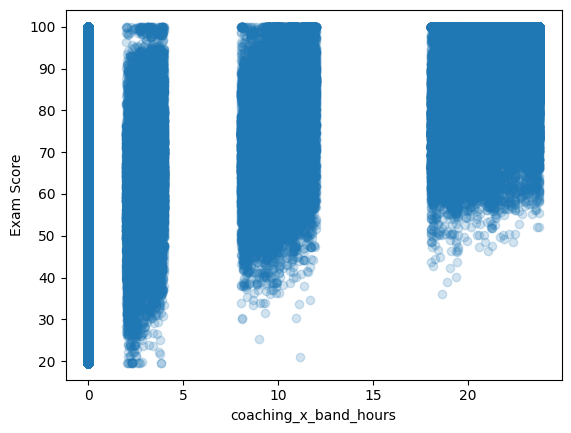

In [12]:
plt.scatter(df["coaching_x_band_hours"], df["exam_score"], alpha=0.2)
plt.xlabel("coaching_x_band_hours")
plt.ylabel("Exam Score")
plt.show()

In [13]:
df.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,study_band,band_x_hours,coaching_x_band_hours
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3,3,23.73,0.00
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7,2,9.90,0.00
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0,2,9.36,9.36
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9,0,0.00,0.00
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0,3,22.95,0.00


In [14]:
df.groupby("sleep_quality")["exam_score"].median()

sleep_quality
average    62.6
good       68.2
poor       57.2
Name: exam_score, dtype: float64

In [15]:
sleep_map = {'average':0, 'poor':1, 'good':2}
df['sleep_quality'] = df['sleep_quality'].map(sleep_map)
#Test Data
test_df['sleep_quality'] = test_df['sleep_quality'].map(sleep_map)

In [16]:
df["sleep_effectiveness"] = df["sleep_hours"] * df["sleep_quality"]
test_df["sleep_effectiveness"] = test_df["sleep_hours"] * test_df["sleep_quality"]

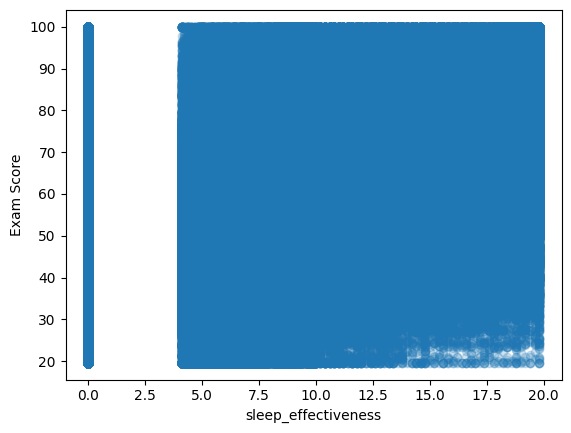

In [17]:
plt.scatter(df["sleep_effectiveness"], df["exam_score"], alpha=0.2)
plt.xlabel("sleep_effectiveness")
plt.ylabel("Exam Score")
plt.show()

In [18]:
df.groupby("facility_rating")["exam_score"].median()

facility_rating
high      67.3
low       58.3
medium    63.1
Name: exam_score, dtype: float64

In [19]:
facility_map = {'low':-5, 'medium':0, 'high':4.2}
df['facility_rating'] = df['facility_rating'].map(facility_map)
#Test Data
test_df['facility_rating'] = test_df['facility_rating'].map(facility_map)

In [20]:
df["class_attendance_band"] = pd.cut(
    df["class_attendance"],
    bins=[40, 60, 80, 100],
    labels=[0, 1, 2]
)
test_df["class_attendance_band"] = pd.cut(
    test_df["class_attendance"],
    bins=[40, 60, 80, 100],
    labels=[0, 1, 2]
)

In [21]:
df.groupby("class_attendance_band")["exam_score"].median()

C:\Users\rajes\AppData\Local\Temp\ipykernel_20808\2548986831.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("class_attendance_band")["exam_score"].median()


class_attendance_band
0    53.6
1    62.0
2    70.0
Name: exam_score, dtype: float64

In [22]:
df.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,study_band,band_x_hours,coaching_x_band_hours,sleep_effectiveness,class_attendance_band
0,0,21,female,b.sc,7.91,98.8,no,4.9,0,online videos,-5.0,easy,78.3,3,23.73,0.00,0.0,2
1,1,18,other,diploma,4.95,94.8,yes,4.7,1,self-study,0.0,moderate,46.7,2,9.90,0.00,4.7,2
2,2,20,female,b.sc,4.68,92.6,yes,5.8,1,coaching,4.2,moderate,99.0,2,9.36,9.36,5.8,2
3,3,19,male,b.sc,2.00,49.5,yes,8.3,0,group study,4.2,moderate,63.9,0,0.00,0.00,0.0,0
4,4,23,male,bca,7.65,86.9,yes,9.6,2,self-study,4.2,easy,100.0,3,22.95,0.00,19.2,2


In [23]:
df.groupby("study_method")["exam_score"].median()


study_method
coaching         69.3
group study      60.8
mixed            65.7
online videos    59.6
self-study       57.3
Name: exam_score, dtype: float64

In [67]:
df.groupby(["study_band", "study_method"])["exam_score"].median()


C:\Users\rajes\AppData\Local\Temp\ipykernel_11764\2476952877.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["study_band", "study_method"])["exam_score"].median()


study_band  study_method 
0           coaching         49.7
            group study      42.8
            mixed            45.2
            online videos    41.1
            self-study       40.1
1           coaching         61.2
            group study      55.2
            mixed            58.9
            online videos    54.1
            self-study       52.2
2           coaching         74.3
            group study      67.1
            mixed            70.7
            online videos    66.7
            self-study       65.4
3           coaching         88.4
            group study      79.2
            mixed            82.0
            online videos    78.3
            self-study       77.1
Name: exam_score, dtype: float64

In [24]:
income_map = {'easy':-5, 'moderate':0, 'hard':5}
df['exam_difficulty'] = df['exam_difficulty'].map(income_map)
#Test Data
test_df['exam_difficulty'] = test_df['exam_difficulty'].map(income_map)

In [25]:
income_map = {'no':0, 'yes':5}
df['internet_access'] = df['internet_access'].map(income_map)
#Test Data
test_df['internet_access'] = test_df['internet_access'].map(income_map)

In [26]:
df.head()
# test_df.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score,study_band,band_x_hours,coaching_x_band_hours,sleep_effectiveness,class_attendance_band
0,0,21,female,b.sc,7.91,98.8,0,4.9,0,online videos,-5.0,-5,78.3,3,23.73,0.00,0.0,2
1,1,18,other,diploma,4.95,94.8,5,4.7,1,self-study,0.0,0,46.7,2,9.90,0.00,4.7,2
2,2,20,female,b.sc,4.68,92.6,5,5.8,1,coaching,4.2,0,99.0,2,9.36,9.36,5.8,2
3,3,19,male,b.sc,2.00,49.5,5,8.3,0,group study,4.2,0,63.9,0,0.00,0.00,0.0,0
4,4,23,male,bca,7.65,86.9,5,9.6,2,self-study,4.2,-5,100.0,3,22.95,0.00,19.2,2


In [27]:
df1 = pd.get_dummies(df, columns=['gender'])
df2 = pd.get_dummies(df1, columns=['study_method'])
df3 = pd.get_dummies(df2, columns=['course'])
df3.head()
test_df1 = pd.get_dummies(test_df, columns=['gender'])
test_df2 = pd.get_dummies(test_df1, columns=['study_method'])
test_df3 = pd.get_dummies(test_df2, columns=['course'])
test_df3.head()

,id,age,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,study_band,...,study_method_mixed,study_method_online videos,study_method_self-study,course_b.com,course_b.sc,course_b.tech,course_ba,course_bba,course_bca,course_diploma
0,630000,24,6.85,65.2,5,5.2,1,4.2,-5,3,...,False,False,False,False,False,False,True,False,False,False
1,630001,18,6.61,45.0,0,9.3,1,-5.0,-5,3,...,False,False,False,False,False,False,False,False,False,True
2,630002,24,6.60,98.5,5,6.2,2,0.0,0,3,...,False,False,False,False,False,True,False,False,False,False
3,630003,24,3.03,66.3,5,5.7,0,0.0,0,1,...,True,False,False,False,False,False,False,False,False,True
4,630004,20,2.03,42.4,5,9.2,0,-5.0,0,1,...,False,False,False,False,False,True,False,False,False,False


In [54]:
df3.dtypes

id                               int64
age                              int64
study_hours                    float64
class_attendance               float64
internet_access                  int64
sleep_hours                    float64
sleep_quality                    int64
facility_rating                float64
exam_difficulty                  int64
exam_score                     float64
study_band                       int64
band_x_hours                   float64
coaching_x_band_hours          float64
sleep_effectiveness            float64
class_attendance_band         category
gender_female                     bool
gender_male                       bool
gender_other                      bool
study_method_coaching             bool
study_method_group study          bool
study_method_mixed                bool
study_method_online videos        bool
study_method_self-study           bool
course_b.com                      bool
course_b.sc                       bool
course_b.tech            

In [55]:
df3["class_attendance_band"] = df3["class_attendance_band"].astype(int)
test_df3["class_attendance_band"] = test_df3["class_attendance_band"].astype(int)


In [65]:

# X = df3.drop(['exam_score','id'], axis=1)
X = df3[['study_hours','band_x_hours','class_attendance','facility_rating','sleep_effectiveness','sleep_quality','coaching_x_band_hours','sleep_hours','study_method_coaching','study_method_mixed','study_method_self-study','study_method_online videos','study_method_group study']]
y = df3['exam_score']
#Test Data
# test_y = test_df3.drop(['id'], axis=1)
test_y= test_df3[['study_hours','band_x_hours','class_attendance','facility_rating','sleep_effectiveness','sleep_quality','coaching_x_band_hours','sleep_hours','study_method_coaching','study_method_mixed','study_method_self-study','study_method_online videos','study_method_group study']]

In [29]:
df3.describe()

,id,age,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,exam_score,study_band,band_x_hours,coaching_x_band_hours,sleep_effectiveness
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.00000,630000.000000
mean,314999.500000,20.545821,4.002337,71.987261,4.598595,7.072758,1.015640,-0.328606,-0.611603,62.506672,1.503083,8.595032,1.89868,7.196903
std,181865.479132,2.260238,2.359880,17.430098,1.358639,1.744811,0.812767,3.744177,3.252546,18.916884,1.128014,8.289761,5.31874,6.221389
min,0.000000,17.000000,0.080000,40.600000,0.000000,4.100000,0.000000,-5.000000,-5.000000,19.599000,0.000000,0.000000,0.00000,0.000000
25%,157499.750000,19.000000,1.970000,57.000000,5.000000,5.600000,0.000000,-5.000000,-5.000000,48.800000,0.000000,0.000000,0.00000,0.000000
50%,314999.500000,21.000000,4.000000,72.600000,5.000000,7.100000,1.000000,0.000000,0.000000,62.600000,1.000000,4.000000,0.00000,7.200000
75%,472499.250000,23.000000,6.050000,87.200000,5.000000,8.600000,2.000000,4.200000,0.000000,76.300000,3.000000,18.150000,0.00000,11.400000
max,629999.000000,24.000000,7.910000,99.400000,5.000000,9.900000,2.000000,4.200000,5.000000,100.000000,3.000000,23.730000,23.73000,19.800000


In [30]:
df.groupby("study_band")["exam_score"].median()


study_band
0    43.8
1    56.3
2    68.9
3    81.3
Name: exam_score, dtype: float64

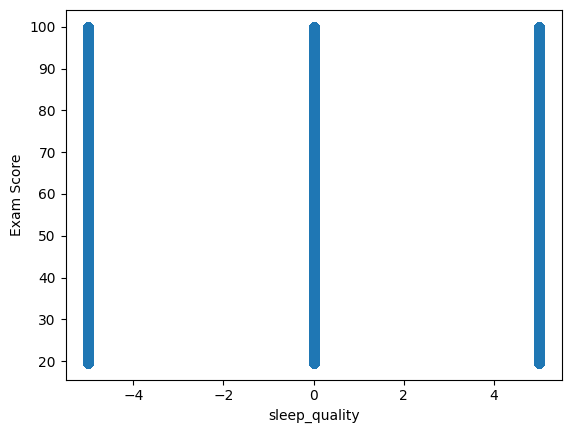

In [61]:
plt.scatter(df["sleep_quality"], df["exam_score"], alpha=0.2)
plt.xlabel("sleep_quality")
plt.ylabel("Exam Score")
plt.show()

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# X_train = X
# y_train = y
# X_test = X
# y_test = y

In [67]:
# model = LinearRegression()
# model = GradientBoostingRegressor(
#     n_estimators=300,
#     learning_rate=0.05,
#     max_depth=3,
#     random_state=42
# )
# model.fit(X_train,y_train)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test, label=y_test)
dtest_test  = xgb.DMatrix(test_y)

In [68]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": "gbtree",

        # 🔧 Hyperparameters to tune
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
    }

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=params["n_estimators"],
        evals=[(dtest, "valid")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    preds = model.predict(dtest)
    rmse = mean_squared_error(y_test, preds, squared=False)
   

    return rmse
# Score: 8.75342
# params = {
#     "objective": "reg:squarederror",
#     "eval_metric": "rmse",
#     "max_depth": 6,
#     "eta": 0.05,
#     "subsample": 0.8,
#     "colsample_bytree": 0.8,
#     "seed": 42
# }

In [69]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best RMSE:", study.best_value)
print("Best Params:", study.best_params)
# 
# booster = xgb.train(
#     params=params,
#     dtrain=dtrain,
#     num_boost_round=300,
#     evals=[(dtest, "test")],
#     verbose_eval=50
# )

[I 2026-01-26 17:47:11,727] A new study created in memory with name: no-name-072b4b8d-1d10-4250-8977-29513a1f0ea1
c:\Users\rajes\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:47:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()
c:\Users\rajes\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2026-01-26 17:47:22,511] Trial 0 finished with value: 8.785889577775453 and parameters: {'max_depth': 5, 'learning_rate': 0.05619526158441398, 'n_estimators': 250, 'subsample': 0.6883892848120869, 'colsample_bytree': 0.8938233654966508, 'reg_alpha': 0.5329492080482456, 'reg_lambda': 1.243011401082849

Best RMSE: 8.719863699193121
Best Params: {'max_depth': 6, 'learning_rate': 0.07267235075519757, 'n_estimators': 809, 'subsample': 0.8628972764334119, 'colsample_bytree': 0.9159696065754973, 'reg_alpha': 5.300747822061896, 'reg_lambda': 0.3607667448173151}


In [70]:
best_params = study.best_params
best_params.update({
    "objective": "reg:squarederror",
    "eval_metric": "rmse"
})

final_model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=best_params["n_estimators"]
)


c:\Users\rajes\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:05:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [42]:
importances = final_model.feature_importances_

feature_importance = pd.Series(
    importances, 
    index=X_train.columns
).sort_values(ascending=False)

print(feature_importance)

AttributeError: 'Booster' object has no attribute 'feature_importances_'

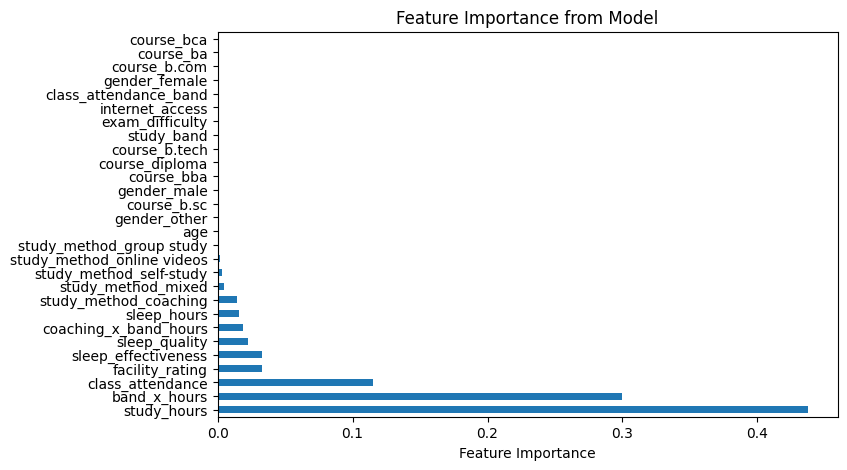

In [183]:
feature_importance.plot(kind='barh', figsize=(8,5))
plt.xlabel("Feature Importance")
plt.title("Feature Importance from Model")
plt.show()

In [71]:
y_pred = final_model.predict(dtest)
test_predictions = final_model.predict(dtest_test)
print(test_predictions)

[70.11854 69.55381 88.1209  ... 90.83721 54.46929 68.34066]


In [72]:
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


R2 Score: 0.7862037647927703
MAE: 6.942141098457215


In [40]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "exam_score": test_predictions
})

In [41]:
submission.to_csv("submission.csv", index=False)

<Axes: xlabel='exam_score', ylabel='Density'>

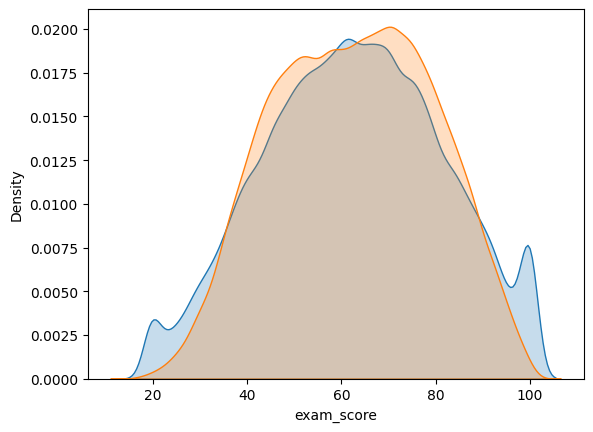

In [73]:
sns.kdeplot(y_test, label="Actual", fill=True)
sns.kdeplot(y_pred, label="Predicted", fill=True)

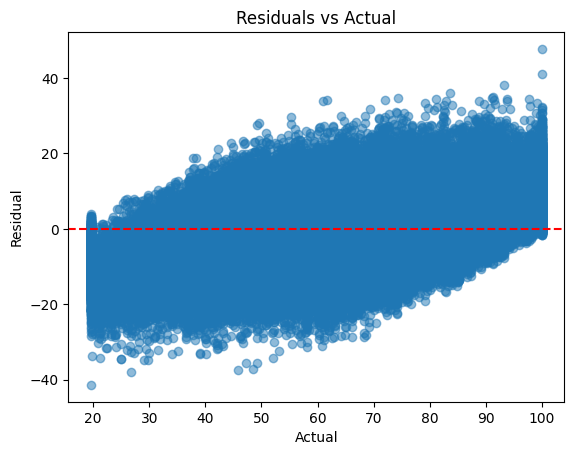

In [74]:
residuals = y_test - y_pred

plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Actual")
plt.ylabel("Residual")
plt.title("Residuals vs Actual")
plt.show()
